## Setup & Imports

You'll need to log into huggingface and accept the terms of the licence for this model - see the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details.

In [1]:
!pip install -q --upgrade transformers diffusers ftfy accelerate

In [2]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [3]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

## Loading the models and helpers

We are loading the models we need and define some helper functions to transform PIL images to latents and vice versa.

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

## MagicMix

This is an implementation of the ByteDance paper "MagicMix: Semantic Mixing with Diffusion Models" from https://arxiv.org/abs/2210.16056.

You pass it the path to an image and a prompt towards which it should adapt the image.

Parameters:

`nu`: controls how much the prompt should overwrite the original image in the initial layout phase. If your result is too close to the original image, try increasing this parameter.

`total_steps`: number of inference steps for stable diffusion

`guidance_scale`: this is the classifier free guidance. The higher this is set, the more it will drive your result towards your prompt.

See example usage below.

In [5]:
def magic_mix(image_path, prompt, nu=0.75, total_steps=50, guidance_scale=7.5):
  with torch.no_grad():
    input_image = Image.open(image_path).resize((512, 512))
    scheduler.set_timesteps(total_steps)

    # Define the details of the two phases. The first phase generates the rough layout, the second phase fine-tunes towards the prompt.
    t_min = round(0.3 * total_steps)
    t_max = round(0.6 * total_steps)
    layout_steps = list(range(total_steps - t_max, total_steps - t_min))
    fine_tune_steps = list(range(total_steps - t_min, total_steps))

    # Get embeddings for the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""], padding="max_length", max_length=max_length, return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    encoded = pil_to_latent(input_image)
    noise = torch.randn_like(encoded)
    fine_tuned = None

    # First phase: generate the rough layout by interpolating the original image with denoising from the prompt
    for i in layout_steps:
      t = scheduler.timesteps[i]
      noisy_latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([t]))
      if fine_tuned is not None:
        noisy_latents = nu * fine_tuned + (1-nu) * noisy_latents
      model_input = torch.cat([noisy_latents] * 2) 
      model_input = scheduler.scale_model_input(model_input, t)

      noise_pred = unet(model_input, t, encoder_hidden_states=text_embeddings).sample

      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      fine_tuned = scheduler.step(noise_pred, t, noisy_latents).prev_sample

    after_layout = fine_tuned

    # Second phase: fine-tune towards the prompt
    for i in fine_tune_steps:
      t = scheduler.timesteps[i]
      model_input = torch.cat([fine_tuned] * 2)
      model_input = scheduler.scale_model_input(model_input, t)

      noise_pred = unet(model_input, t, encoder_hidden_states=text_embeddings).sample

      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      fine_tuned = scheduler.step(noise_pred, t, fine_tuned).prev_sample

  return latents_to_pil(fine_tuned)[0]

## Example usage

We are downloading an image of a flying corgi and then using MagicMix to change it:

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 88646  100 88646    0     0  48679      0  0:00:01  0:00:01 --:--:-- 48679


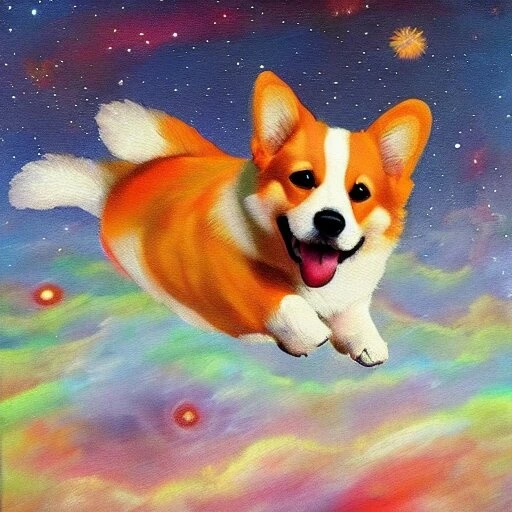

In [6]:
!curl --output corgi.webp 'https://www.thisshirtexists.com/wp-content/uploads/sd-gallery/corgi-flying-over-rainbow-clouds.webp'
input_image = Image.open('corgi.webp').resize((512, 512))
input_image

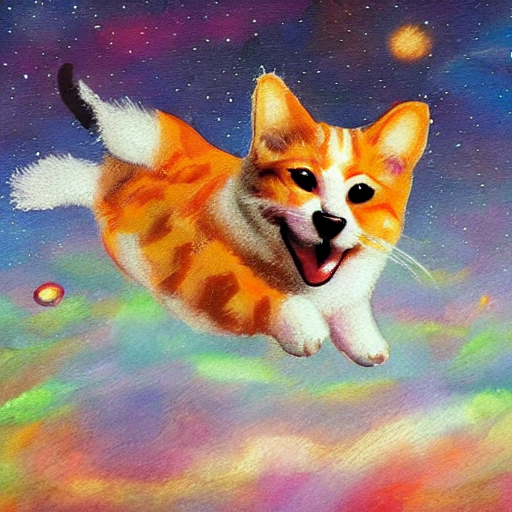

In [7]:
magic_mix('corgi.webp', 'cat')

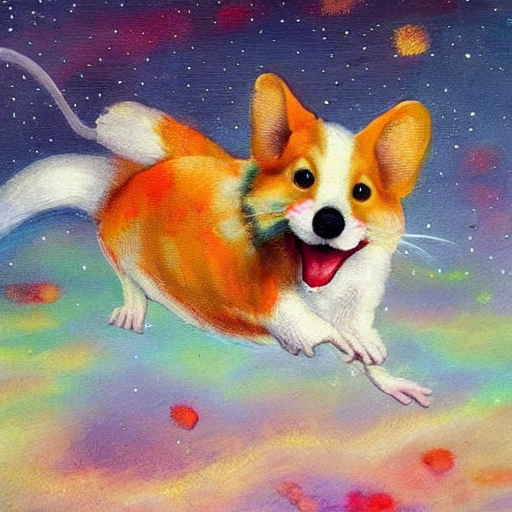

In [24]:
magic_mix('corgi.webp', 'mouse')

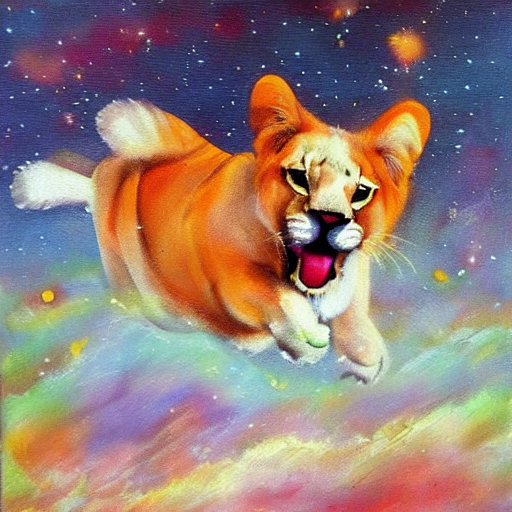

In [9]:
magic_mix('corgi.webp', 'lion')

## Tuning MagicMix

For the macaw, the initial results were not as good, so I increased nu / guidance_scale:

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0   227k      0 --:--:-- --:--:-- --:--:--  227k


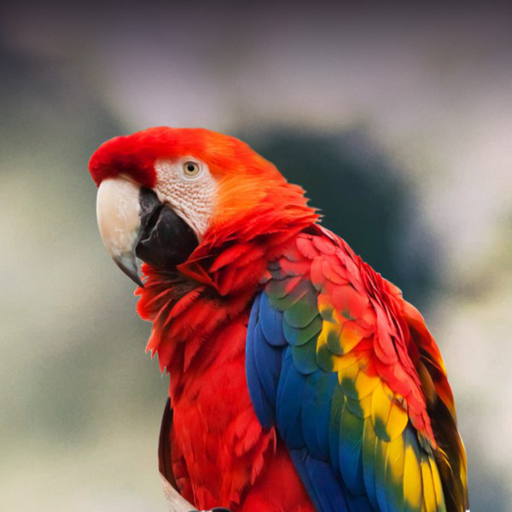

In [10]:
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

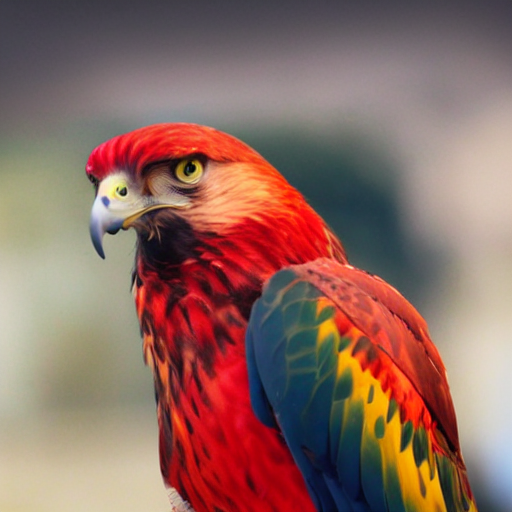

In [22]:
magic_mix('macaw.jpg', 'hawk', nu=0.9)

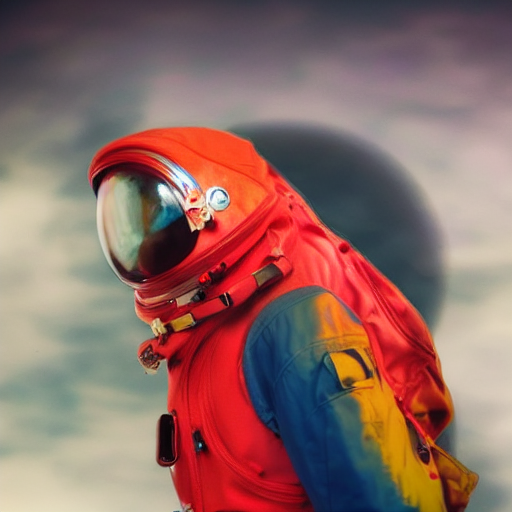

In [12]:
magic_mix('macaw.jpg', 'astronaut', nu=0.9)

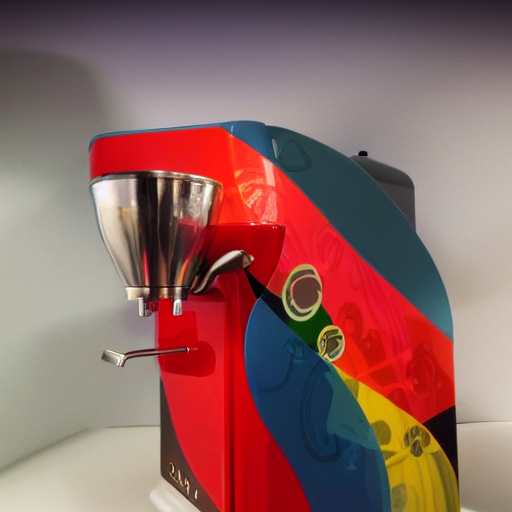

In [20]:
magic_mix('macaw.jpg', 'coffee machine', nu=0.9, guidance_scale=12)